In [1]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from tqdm import tqdm

In [3]:


import yaml

parameters = yaml.safe_load(open("/home/felipe/Projects/roco-image-captioning/config.yaml"))
from pprint import pprint

pprint(parameters)


{'dataset': {'test_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/test_dataset.json',
             'train_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/train_dataset.json',
             'validation_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/validation_dataset.json'},
 'input_size': [224, 224],
 'optimizer': {'lr': 0.0001,
               'lr_scheduler_rate': 0.1,
               'method': 'adam',
               'weight_decay': 0.0},
 'registry': {'checkpoints_dir': 'outputs/model_checkpoints',
              'name': 'roco-clip',
              'project': 'roco-debug',
              'wandb_root_dir': 'outputs/wandb_outputs'},
 'train': {'batch_size': 4,
           'early_stopping_patience': 5,
           'gradient_clip_val': 100.0,
           'limit_train_batches': 0.1,
           'log_every_n_steps': 4,
           'max_epochs': 10,
           'max_seq_length': 70}}


In [ ]:
from src.lib.dataset.ROCODataset import ImageTextDataset
from src.lib.dataset.ROCODataset_withKeywords import ImageTextDataset_withKeywords

from src.lib.model.clip import MedCLIP
from src.lib.data_transform.collate import collate_clip

In [4]:
import sys


def print_model_memory_usage(model):
    # Estimate CPU memory usage (approximate, for loaded model weights)
    param_size = sum(param.numel() for param in model.parameters())
    buffer_size = sum(buffer.numel() for buffer in model.buffers())
    memory_size = (param_size + buffer_size) * 4 / (1024 ** 2)  # Assuming float32 (4 bytes)
    print(f"Estimated model size on CPU: {memory_size:.2f} MB")

    # Check if CUDA is available and print GPU memory usage
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model.to(device)  # Move model to GPU
        torch.cuda.synchronize()  # Sync to avoid race conditions
        allocated = torch.cuda.memory_allocated(device) / (1024 ** 2)
        reserved = torch.cuda.memory_reserved(device) / (1024 ** 2)
        print(f"GPU memory allocated after loading model: {allocated:.2f} MB")
        print(f"GPU memory reserved after loading model: {reserved:.2f} MB")
        model.to('cpu')  # Move back to CPU after checking
    else:
        print("CUDA is not available.")


In [5]:
model = MedCLIP.load_from_checkpoint(
    "/home/felipe/Projects/roco-image-captioning/outputs/model_checkpoints/epoch=3.ckpt",
    strict=False, map_location=torch.device('cpu'))

/home/felipe/Projects/roco-image-captioning/.venv/lib/python3.12/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['labels']


In [6]:
model.labels

tensor([0, 1, 2, 3])

In [7]:
print_model_memory_usage(model)

Estimated model size on CPU: 577.08 MB
GPU memory allocated after loading model: 577.08 MB
GPU memory reserved after loading model: 630.00 MB


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
device

'cuda'

In [9]:
print("Loading test data...")
start = time.perf_counter()
test_data = ImageTextDataset(
    "test", cfg=parameters,
)
print(f"Successfully loaded validation data! Elapsed: {time.perf_counter() - start:.1f} seconds")

test_dataloader = torch.utils.data.DataLoader(
    batch_size=4,
    dataset=test_data,
    shuffle=False,
    num_workers=4,
    drop_last=True,
    collate_fn=collate_clip,
)


Loading test data...
Successfully loaded validation data! Elapsed: 0.1 seconds


In [10]:
model.labels = torch.arange(4)

In [11]:
model.to(device)

MedCLIP(
  (model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_features=512, bias=True)
   

In [84]:
import torchmetrics


def test_step(inputs):
    # compute similarities (contrastive pairs)
    inputs_device = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.model(**inputs_device)
    logits_per_text = outputs.logits_per_text
    logits_per_image = outputs.logits_per_image
    # metrics
    probas = logits_per_image.softmax(dim=1)
    preds = probas.argmax(dim=1)
    accuracy = torchmetrics.functional.accuracy(
        preds, model.labels, task="multiclass", num_classes=len(model.labels)
    )
    mcc = torchmetrics.functional.matthews_corrcoef(
        preds, model.labels, task="multiclass", num_classes=len(model.labels)
    )
    return accuracy, mcc

In [85]:
acc_total = 0
mcc_total = 0
count = 0

model.eval()

pbar = tqdm(total=len(test_dataloader),
            desc="test...", leave=False)

for batch in test_dataloader:
    acc, mcc = test_step(batch)

    acc_total += acc.item()
    mcc_total += mcc.item()
    count += 1

    pbar.set_description(f"test: {100 * acc_total / count:.4f} %")
    pbar.update()

test...:   0%|          | 0/255 [00:00<?, ?it/s]
                                                

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 3.71 GiB of which 7.31 MiB is free. Including non-PyTorch memory, this process has 3.70 GiB memory in use. Of the allocated memory 3.45 GiB is allocated by PyTorch, and 150.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [86]:
torch.cuda.empty_cache()

In [64]:
pprint(
    {
        "accuracy": acc_total / count,
        "mcc": mcc_total / count,
        "count": count,
    }
)

{'accuracy': 0.24975526186979932, 'count': 2043, 'mcc': -0.0005542231697226295}


In [65]:
model.labels

tensor([0, 1, 2, 3], device='cuda:0')

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from tqdm import tqdm
import yaml

parameters = yaml.safe_load(open("/home/felipe/Projects/roco-image-captioning/config.yaml"))
from pprint import pprint

pprint(parameters)

from src.lib.dataset.ROCODataset_withKeywords import ImageTextDataset_withKeywords

from src.lib.data_transform.collate import collate_clip

{'dataset': {'test_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/test_dataset.json',
             'train_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/train_dataset.json',
             'validation_json': '/home/felipe/Projects/roco-image-captioning/roco-dataset/json/validation_dataset.json'},
 'input_size': [224, 224],
 'optimizer': {'lr': 1e-05,
               'lr_scheduler_patience': 1,
               'lr_scheduler_rate': 0.1,
               'method': 'adam',
               'weight_decay': 0.0005},
 'registry': {'checkpoints_dir': 'outputs/model_checkpoints',
              'name': 'roco-clip',
              'project': 'roco-debug',
              'wandb_root_dir': 'outputs/wandb_outputs'},
 'train': {'batch_size': 64,
           'early_stopping_patience': 5,
           'gradient_clip_val': 10.0,
           'limit_train_batches': 1.0,
           'log_every_n_steps': 4,
           'max_epochs': 10,
           'max_seq_length': 140}}


In [62]:
chest = [
    'breast', 'lung', 'rib', 'thoracotomy', 'pulmonary', 'mediastinal',
    'bronchus', 'bronchoscopic', 'bronchiectasis', 'bronchial',
    'tuberculosis', 'heart', 'ventricle', 'myocardial', 'valve',
    'thorax', 'thoracic', 'echocardiogram', 'echocardiography',
    'angioplasty', 'diaphragm', 'coronary', 'cardiac', 'coronaries',
    'thoracique', 'chest', 'mitral annulus', 'empyema'
]

abdomen = [
    'gastro-oesophageal', 'gastrointestinal', 'gastric',
    'abdomen', 'abdomenal', 'abdominal', 'bowel', 'colon', 'liver',
    'kidney', 'renal', 'stomach', 'ventral', 'esophagus', 'pancreas',
    'pancreatic', 'pancreatitis', 'hernia', 'bladder', 'gallstones',
    'gallbladder', 'spleen', 'splenic', 'appendi', 'intestine',
    'duodenum', 'ileum', 'jejunum', 'rectum', 'ovary', 'uterus',
    'vagina', 'cervix', 'pregnancy', 'cervical', 'prostate', 'penis',
    'testicle', 'testis', 'testicular', 'urethrogram', 'urethra',
    'ureteral', 'ureter', 'peritoneum'
]

head = [
    'head', 'skullbase', 'skull', 'zygoma', 'parieto-occipital',
    'parietooccipital', 'parieto occipital', 'cerebellar', 'cerebellum',
    'brain', 'caudate nucleus', 'caudate', 'ear', 'auditory canal',
    'facial', 'eye', 'sinus', 'gland', 'temporal lobe', 'frontal lobe',
    'frontal bone', 'parietal bone', 'parietal lobe', 'occipital lobe',
    'lymph', 'nose', 'nasal', 'mouth', 'tongue', 'cheek', 'jaw',
    'root canal', 'tooth', 'teeth', 'obturation', 'periapical', 'premolars',
    'dental', 'parotid', 'orthopantomograph', 'orthopantomogram',
    'myelinolysis'
]

neck = ['neck', 'throat', 'theroid', 'thyroid', 'carotid']

spine = ['foraminal', 'spine', 'disk', 'disc', 'spinal', 'lumbosacral', 'thoracic spine', 'lubmar']

pelvic = ['pelvic', 'pelvis', 'hip', 'perineum', 'iliac', 'gluteal']

hand = ['arm', 'shoulder', 'elbow', 'wrist', 'hand', 'nail', 'finger', 'humerus', 'thumb']

leg = [
    'tibias', 'leg', 'thigh', 'foot', 'feet', 'talus', 'toe', 'knee',
    'calcaneus', 'fibula', 'femur', 'femoral', 'femural', 'prosthesis',
    'prostheses', 'limb'
]

vein = ['vein', 'vessel', 'vascular', 'artery', 'angioplasty', 'angiography', 'artial', 'aorta', 'aortogram']

bone = ['bone']


In [63]:
print("Loading test data...")
start = time.perf_counter()
test_data = ImageTextDataset_withKeywords(
    "test", cfg=parameters,
)
print(f"Successfully loaded validation data! Elapsed: {time.perf_counter() - start:.1f} seconds")

Loading test data...
Successfully loaded validation data! Elapsed: 22.2 seconds


In [64]:
test_dataloader = torch.utils.data.DataLoader(
    batch_size=64,
    dataset=test_data,
    shuffle=False,
    num_workers=4,
    drop_last=True,
    collate_fn=collate_clip,
)


In [65]:
dicts = {

    "chest": [],
    "abdomen": [],
    "head": [],
    "neck": [],
    "spine": [],
    "pelvic": [],
    "hand": [],
    "leg": [],
    "vein": [],
    "bone": [],
    "others": [],

}

In [66]:
def clean_string(input_string):
    # Strip leading and trailing whitespace, replace newlines and tabs
    return input_string.strip().replace('\n', '').replace('\t', '')

In [67]:
for i in range(len(test_data)):
    kw, cap = test_data.load_keywords(i)
    for k in kw:
        k = clean_string(k)
        found = False
        if k in chest:
            dicts["chest"].append(i)
            found = True
        if k in abdomen:
            dicts["abdomen"].append(i)
            found = True
        if k in head:
            dicts["head"].append(i)
            found = True
        if k in neck:
            dicts["neck"].append(i)
            found = True
        if k in spine:
            dicts["spine"].append(i)
            found = True
        if k in pelvic:
            dicts["pelvic"].append(i)
            found = True
        if k in hand:
            dicts["hand"].append(i)
            found = True
        if k in leg:
            dicts["leg"].append(i)
            found = True
        if k in vein:
            dicts["vein"].append(i)
            found = True
        if k in bone:
            dicts["bone"].append(i)
            found = True

        if not found:
            dicts["others"].append(i)


In [68]:
dicts_counts = {
    k: len(dicts[k]) for k in dicts
}

In [69]:
dicts_counts

{'chest': 2264,
 'abdomen': 2006,
 'head': 984,
 'neck': 266,
 'spine': 249,
 'pelvic': 267,
 'hand': 176,
 'leg': 374,
 'vein': 1101,
 'bone': 243,
 'others': 87418}

In [72]:
import pandas as pd
import seaborn as sns

# Compute the co-occurrence probabilities
groups = [key for key in dicts.keys() if key != "others"]
n = len(groups)
probabilities = pd.DataFrame(index=groups, columns=groups)

for group_x in groups:
    set_x = set(dicts[group_x])
    for group_y in groups:
        set_y = set(dicts[group_y])
        if len(set_y) > 0:  # Avoid division by zero
            co_occurrence = len(set_x & set_y) / len(set_y)
            probabilities.loc[group_x, group_y] = co_occurrence
        else:
            probabilities.loc[group_x, group_y] = 0

# Convert to numeric values
probabilities = probabilities.astype(float)

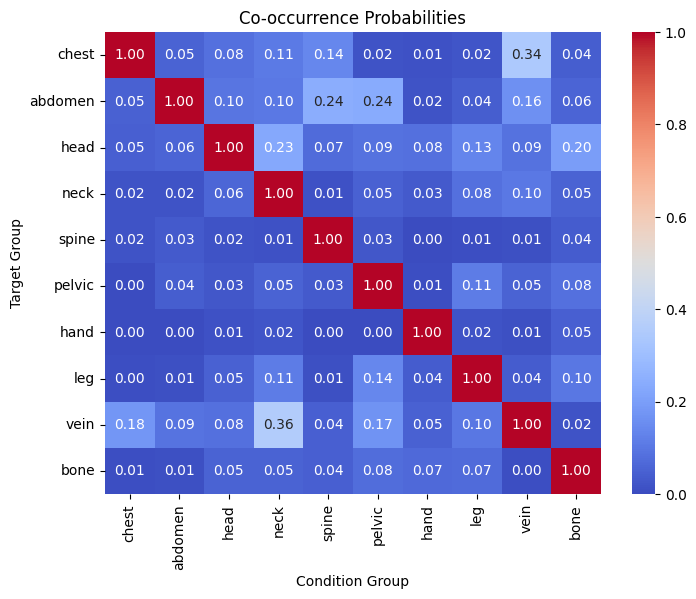

In [73]:

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(probabilities, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Co-occurrence Probabilities")
plt.xlabel("Condition Group")
plt.ylabel("Target Group")
plt.show()

In [74]:
# Compute overlap (Jaccard similarity)
overlap_matrix = pd.DataFrame(index=groups, columns=groups)

for group_x in groups:
    set_x = set(dicts[group_x])
    for group_y in groups:
        set_y = set(dicts[group_y])
        if set_x or set_y:  # Avoid division by zero
            jaccard_similarity = len(set_x & set_y) / len(set_x | set_y)
            overlap_matrix.loc[group_x, group_y] = jaccard_similarity
        else:
            overlap_matrix.loc[group_x, group_y] = 0

# Convert to numeric values
overlap_matrix = overlap_matrix.astype(float)


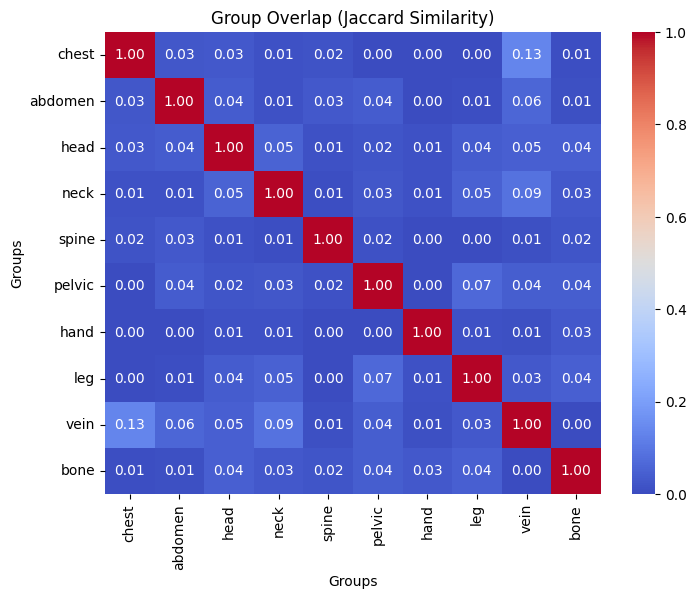

In [75]:

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(overlap_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Jaccard Similarity")
plt.xlabel("Groups")
plt.ylabel("Groups")
plt.show()

In [14]:
dicts_counts_ = {k: v for k, v in dicts_counts.items() if k != "others"}

Text(0.5, 1.0, 'Keyword Distribution - Test Dataset')

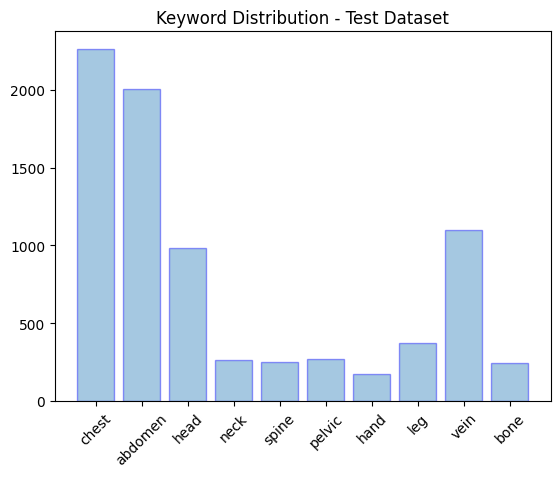

In [16]:
bars = plt.bar(dicts_counts_.keys(), dicts_counts_.values(), edgecolor='blue', alpha=0.4)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45)

# Add labels and title (optional)
# plt.xlabel('Categories')
# plt.ylabel('Counts')
plt.title('Keyword Distribution - Test Dataset')

In [17]:
tsne_dict = {k: v for k, v in dicts.items() if
             k in ["chest", "abdomen", "head", "neck", "spine", "pelvic", "hand", "leg", "vein", "bone"]}




In [18]:
tsne_dict.keys()

dict_keys(['chest', 'abdomen', 'head', 'neck', 'spine', 'pelvic', 'hand', 'leg', 'vein', 'bone'])

In [19]:
from transformers import CLIPProcessor

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [20]:
tsne_text_inputs = []
tsne_image_inputs = []

tsne_labels = []

In [21]:
# 0 - chest
# 1 - abdomen
# 2 - head

name_to_index = {
    "chest": 0,
    "abdomen": 1,
    "head": 2,
    "neck": 3,
    "spine": 4,
    "pelvic": 5,
    "hand": 6,
    "leg": 7,
    "vein": 8,
    "bone": 9,
}



In [23]:
from src.lib.model.clip import MedCLIP

model = MedCLIP.load_from_checkpoint(
    "/home/felipe/Projects/roco-image-captioning/outputs/model_checkpoints/last-v3.ckpt",
    strict=False, map_location=torch.device('cpu'))

In [26]:
for name, proxy in tsne_dict.items():
    index = name_to_index.get(name, None)
    for i in proxy:
        images, targets = test_data[i]
        inputs = processor(text=targets, images=images, return_tensors="pt", padding=True, do_rescale=False)
        text_features, image_features = model.extract_features(inputs)
        tsne_text_inputs.append(text_features.detach().numpy())
        tsne_image_inputs.append(image_features.detach().numpy())
        tsne_labels.append(index)

In [27]:
# Stack arrays and save
np.savez('tsne_data.npz',
         text=np.stack(tsne_text_inputs),
         image=np.stack(tsne_image_inputs),
         label=np.stack(tsne_labels))



In [101]:
index_to_name = {k: v for v, k in name_to_index.items()}

In [102]:

# Loading back the data
loaded_data = np.load('tsne_data.npz')
text_loaded = loaded_data['text']
image_loaded = loaded_data['image']
label_loaded = loaded_data['label']

In [103]:
text_loaded.shape

(7930, 1, 512)

In [104]:
image_loaded.shape

(7930, 1, 512)

In [105]:
label_loaded.shape

(7930,)

In [106]:
np.unique(label_loaded)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [107]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [108]:
pca = PCA(n_components=50)
reduced_data = pca.fit_transform(text_loaded.squeeze())
text_loaded_tsne = TSNE(n_components=2, learning_rate='auto',
                        init='random', perplexity=30).fit_transform(reduced_data)


In [109]:
pca = PCA(n_components=50)
reduced_data = pca.fit_transform(image_loaded.squeeze())
image_loaded_tsne = TSNE(n_components=2, learning_rate='auto',
                         init='random', perplexity=30).fit_transform(reduced_data)


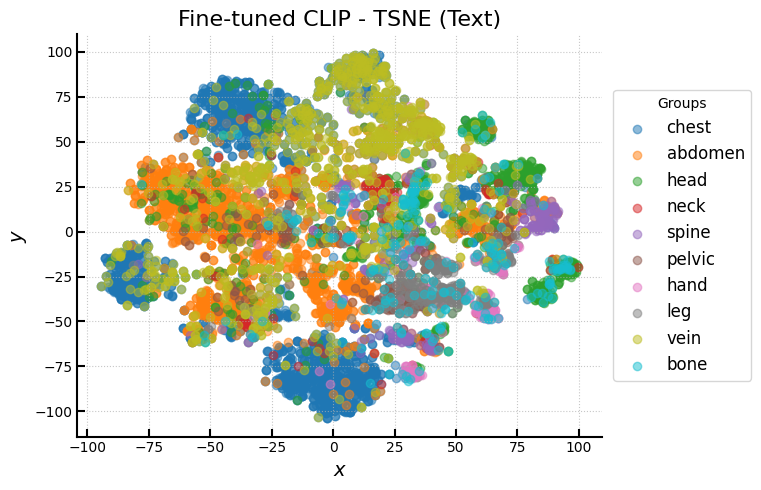

In [110]:
# Set plot size
plt.figure(figsize=(8, 5))

colors = [f"C{i}" for i in range(len(tsne_dict))]
# Plot with custom styles
for i in range(len(tsne_dict)):
    
    label = index_to_name[i]
    mask = (label_loaded == i)
    plt.scatter(text_loaded_tsne[mask, 0], text_loaded_tsne[mask, 1], label=label, marker='o', edgecolors=colors[i],
                facecolors=colors[i], alpha=0.5)

# Grid, legend, and labels
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
plt.legend(loc='center right', fontsize=12, bbox_to_anchor=(1.3, 0.5), title="Groups")
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title(r'Fine-tuned CLIP - TSNE (Text)', fontsize=16)

# Fine-tune axes appearance
plt.tick_params(axis='both', direction='in', length=6, width=1.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Show the plot
plt.tight_layout()
plt.savefig("tsne-finetuned-text.pdf")
plt.show()

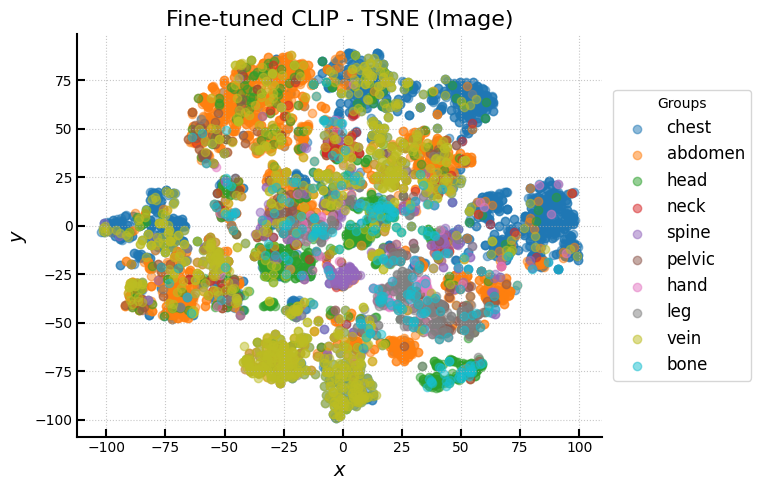

In [111]:
# Set plot size
plt.figure(figsize=(8, 5))

colors = [f"C{i}" for i in range(len(tsne_dict))]
# Plot with custom styles
for i in range(len(tsne_dict)):
    label = index_to_name[i]
    mask = (label_loaded == i)
    plt.scatter(image_loaded_tsne[mask, 0], image_loaded_tsne[mask, 1], label=label, marker='o', edgecolors=colors[i],
                facecolors=colors[i], alpha=0.5)

# Grid, legend, and labels
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
plt.legend(loc='center right', fontsize=12, bbox_to_anchor=(1.3, 0.5), title="Groups")

plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title(r'Fine-tuned CLIP - TSNE (Image)', fontsize=16)

# Fine-tune axes appearance
plt.tick_params(axis='both', direction='in', length=6, width=1.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Show the plot
plt.tight_layout()
plt.savefig("tsne-finetuned-image.pdf")
plt.show()

In [52]:
from transformers import CLIPProcessor, CLIPModel

base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32",
                                           attn_implementation="sdpa")

In [54]:
for name, proxy in tsne_dict.items():
    index = name_to_index.get(name, None)
    for i in proxy:
        images, targets = test_data[i]
        inputs = processor(text=targets, images=images, return_tensors="pt", padding=True, do_rescale=False)
        
        text_features = base_model.get_text_features(input_ids=inputs["input_ids"],
                                             attention_mask=inputs["attention_mask"], )
        image_features = base_model.get_image_features(pixel_values=inputs["pixel_values"], )
        
        tsne_text_inputs.append(text_features.detach().numpy())
        tsne_image_inputs.append(image_features.detach().numpy())
        tsne_labels.append(index)

In [55]:
# Stack arrays and save
np.savez('tsne_base_data.npz',
         text=np.stack(tsne_text_inputs),
         image=np.stack(tsne_image_inputs),
         label=np.stack(tsne_labels))



In [112]:
# Loading back the data
loaded_data = np.load('tsne_base_data.npz')
text_loaded = loaded_data['text']
image_loaded = loaded_data['image']
label_loaded = loaded_data['label']

In [117]:

pca = PCA(n_components=50)
reduced_data = pca.fit_transform(text_loaded.squeeze())
text_loaded_tsne = TSNE(n_components=2, learning_rate='auto',
                        init='random', perplexity=30).fit_transform(reduced_data)


In [118]:

pca = PCA(n_components=50)
reduced_data = pca.fit_transform(image_loaded.squeeze())
image_loaded_tsne = TSNE(n_components=2, learning_rate='auto',
                         init='random', perplexity=30).fit_transform(reduced_data)


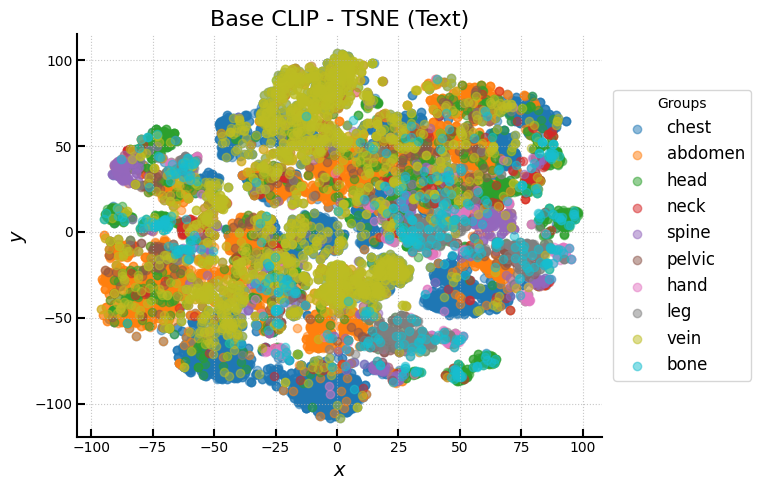

In [122]:
# Set plot size
plt.figure(figsize=(8, 5))

colors = [f"C{i}" for i in range(len(tsne_dict))]
# Plot with custom styles
for i in range(len(tsne_dict)):
    label = index_to_name[i]
    mask = (label_loaded == i)
    plt.scatter(text_loaded_tsne[mask, 0], text_loaded_tsne[mask, 1], label=label, marker='o', edgecolors=colors[i],
                facecolors=colors[i], alpha=0.5)

# Grid, legend, and labels
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
plt.legend(loc='center right', fontsize=12, bbox_to_anchor=(1.3, 0.5), title="Groups")
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title(r'Base CLIP - TSNE (Text)', fontsize=16)

# Fine-tune axes appearance
plt.tick_params(axis='both', direction='in', length=6, width=1.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Show the plot
plt.tight_layout()
plt.savefig("tsne-base-text.pdf")
plt.show()

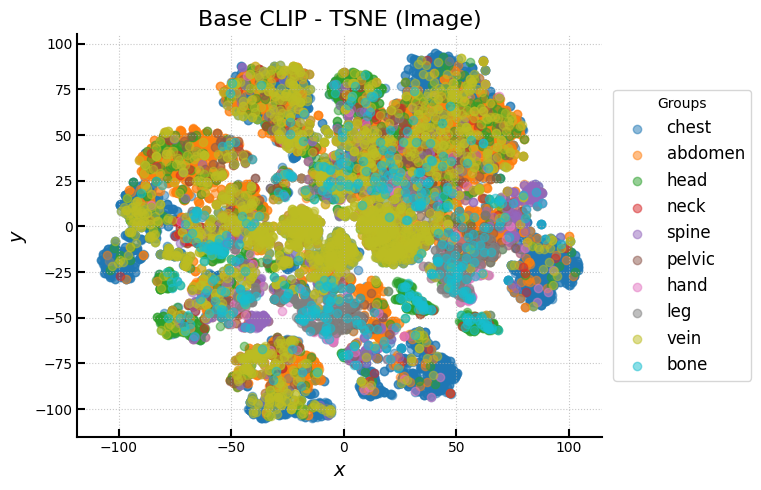

In [120]:
# Set plot size
plt.figure(figsize=(8, 5))

colors = [f"C{i}" for i in range(len(tsne_dict))]
# Plot with custom styles
for i in range(len(tsne_dict)):
    label = index_to_name[i]
    mask = (label_loaded == i)
    plt.scatter(image_loaded_tsne[mask, 0], image_loaded_tsne[mask, 1], label=label, marker='o', edgecolors=colors[i],
                facecolors=colors[i], alpha=0.5)

# Grid, legend, and labels
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
plt.legend(loc='center right', fontsize=12, bbox_to_anchor=(1.3, 0.5), title="Groups")

plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title(r'Base CLIP - TSNE (Image)', fontsize=16)

# Fine-tune axes appearance
plt.tick_params(axis='both', direction='in', length=6, width=1.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Show the plot
plt.tight_layout()
plt.savefig("tsne-base-image.pdf")
plt.show()

In [92]:
from sklearn.decomposition import PCA

In [93]:
text_loaded_pca = PCA(n_components=2).fit_transform(text_loaded.squeeze())

In [94]:
image_loaded_pca = PCA(n_components=2).fit_transform(image_loaded.squeeze())

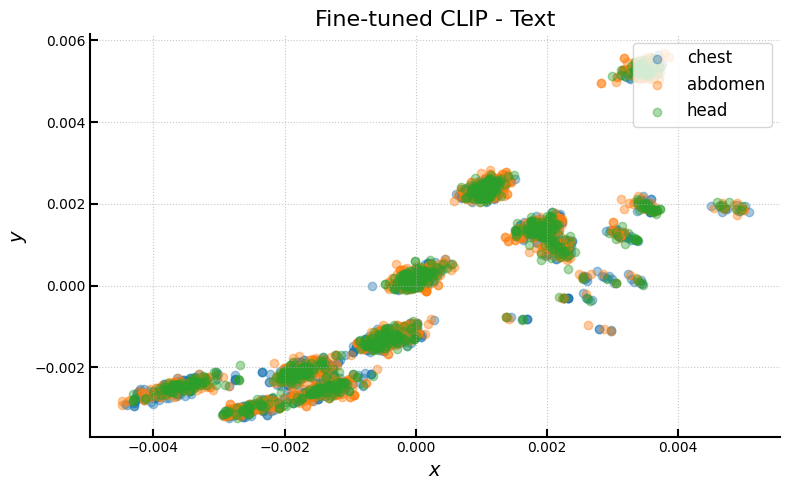

In [95]:
# Set plot size
plt.figure(figsize=(8, 5))

colors = ["C0", "C1", "C2"]
# Plot with custom styles
for i in range(3):
    label = index_to_name[i]
    mask = (label_loaded == i)
    plt.scatter(text_loaded_pca[mask, 0], text_loaded_pca[mask, 1], label=label, marker='o', edgecolors=colors[i],
                facecolors=colors[i], alpha=0.4)

# Grid, legend, and labels
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title(r'Fine-tuned CLIP - Text', fontsize=16)

# Fine-tune axes appearance
plt.tick_params(axis='both', direction='in', length=6, width=1.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Show the plot
plt.tight_layout()
plt.show()

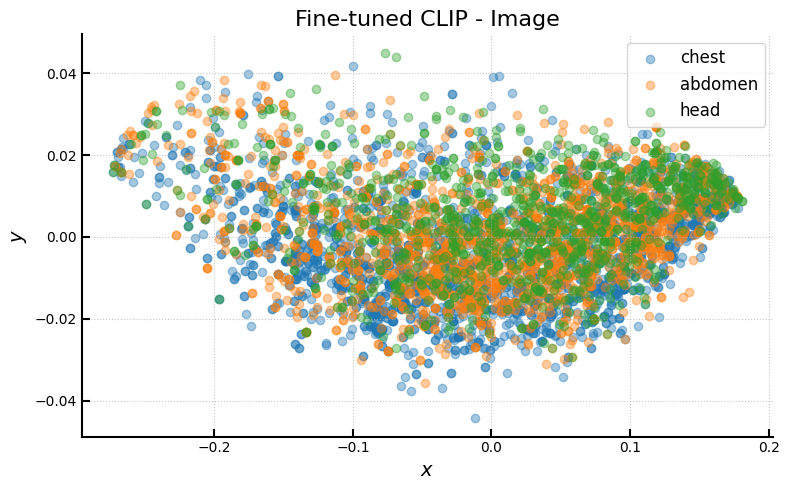

In [96]:
# Set plot size
plt.figure(figsize=(8, 5))

colors = ["C0", "C1", "C2"]
# Plot with custom styles
for i in range(3):
    label = index_to_name[i]
    mask = (label_loaded == i)
    plt.scatter(image_loaded_pca[mask, 0], image_loaded_pca[mask, 1], label=label, marker='o', edgecolors=colors[i],
                facecolors=colors[i], alpha=0.4)

# Grid, legend, and labels
plt.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$y$', fontsize=14)
plt.title(r'Fine-tuned CLIP - Image', fontsize=16)

# Fine-tune axes appearance
plt.tick_params(axis='both', direction='in', length=6, width=1.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Show the plot
plt.tight_layout()
plt.show()